## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
  
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 20
model_layers = [512, 256]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/a' + str(i))

print(models, model_names)

inputs = ['a', 'b']
target = ['c']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256]] ['temp/a0', 'temp/a1', 'temp/a2', 'temp/a3', 'temp/a4', 'temp/a5', 'temp/a6', 'temp/a7', 'temp/a8', 'temp/a9', 'temp/a10', 'temp/a11', 'temp/a12', 'temp/a13', 'temp/a14', 'temp/a15', 'temp/a16', 'temp/a17', 'temp/a18', 'temp/a19']


In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/a0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.1677 - mean_squared_error: 1.1677 - val_loss: 1.0281 - val_mean_squared_error: 1.0281

Epoch 00001: val_loss improved from inf to 1.02810, saving model to temp/a0
Epoch 2/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0278 - mean_squared_error: 1.0278 - val_loss: 1.0271 - val_mean_squared_error: 1.0271

Epoch 00002: val_loss improved from 1.02810 to 1.02712, saving model to temp/a0
Epoch 3/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0191 - mean_squared_error: 1.0191 - val_loss: 1.0171 - val_mean_squared_error: 1.0171

Epoch 00003: val_loss improved from 1.02712 to 1.01711, saving model to temp/a0
Epoch 4/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0236 - mean_squared_error: 1.0236 - val_loss: 1.0130 - val_mean_squared_error: 1.0130

Epoch 00004: val_loss improved

20000/20000 [==============================] - 2s 115us/step - loss: 1.0076 - mean_squared_error: 1.0076 - val_loss: 1.0100 - val_mean_squared_error: 1.0100

Epoch 00010: val_loss did not improve from 1.00827
Epoch 00010: early stopping
temp/a4
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.1915 - mean_squared_error: 1.1915 - val_loss: 1.0335 - val_mean_squared_error: 1.0335

Epoch 00001: val_loss improved from inf to 1.03351, saving model to temp/a4
Epoch 2/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0273 - mean_squared_error: 1.0273 - val_loss: 1.0264 - val_mean_squared_error: 1.0264

Epoch 00002: val_loss improved from 1.03351 to 1.02644, saving model to temp/a4
Epoch 3/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0213 - mean_squared_error: 1.0213 - val_loss: 1.0215 - val_mean_squared_error: 1.0215

Epoch 00003: val_loss improved from 1.0264


Epoch 00002: val_loss did not improve from 1.02223
Epoch 3/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.0152 - mean_squared_error: 1.0152 - val_loss: 1.0149 - val_mean_squared_error: 1.0149

Epoch 00003: val_loss improved from 1.02223 to 1.01491, saving model to temp/a8
Epoch 4/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0202 - mean_squared_error: 1.0202 - val_loss: 1.0145 - val_mean_squared_error: 1.0145

Epoch 00004: val_loss improved from 1.01491 to 1.01450, saving model to temp/a8
Epoch 5/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0181 - mean_squared_error: 1.0181 - val_loss: 1.0168 - val_mean_squared_error: 1.0168

Epoch 00005: val_loss did not improve from 1.01450
Epoch 6/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0248 - val_mean_squared_error: 1.0248

Epoch 00006: val_loss did not improve from 1.01450
Epoch 0000

20000/20000 [==============================] - 2s 103us/step - loss: 1.0233 - mean_squared_error: 1.0233 - val_loss: 1.0197 - val_mean_squared_error: 1.0197

Epoch 00002: val_loss improved from 1.02102 to 1.01965, saving model to temp/a13
Epoch 3/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0234 - mean_squared_error: 1.0234 - val_loss: 1.0170 - val_mean_squared_error: 1.0170

Epoch 00003: val_loss improved from 1.01965 to 1.01703, saving model to temp/a13
Epoch 4/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0170 - mean_squared_error: 1.0170 - val_loss: 1.0111 - val_mean_squared_error: 1.0111

Epoch 00004: val_loss improved from 1.01703 to 1.01108, saving model to temp/a13
Epoch 5/20
20000/20000 [==============================] - 2s 101us/step - loss: 1.0223 - mean_squared_error: 1.0223 - val_loss: 1.0202 - val_mean_squared_error: 1.0202

Epoch 00005: val_loss did not improve from 1.01108
Epoch 6/20
20000/20000 [=================

20000/20000 [==============================] - 2s 104us/step - loss: 1.0088 - mean_squared_error: 1.0088 - val_loss: 1.0248 - val_mean_squared_error: 1.0248

Epoch 00006: val_loss did not improve from 1.01604
Epoch 7/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0168 - mean_squared_error: 1.0168 - val_loss: 1.0146 - val_mean_squared_error: 1.0146

Epoch 00007: val_loss improved from 1.01604 to 1.01456, saving model to temp/a18
Epoch 8/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0160 - mean_squared_error: 1.0160 - val_loss: 1.0179 - val_mean_squared_error: 1.0179

Epoch 00008: val_loss did not improve from 1.01456
Epoch 9/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0168 - mean_squared_error: 1.0168 - val_loss: 1.0136 - val_mean_squared_error: 1.0136

Epoch 00009: val_loss improved from 1.01456 to 1.01361, saving model to temp/a18
Epoch 10/20
20000/20000 [==============================] - 2s 106us/ste

In [4]:
nb_test = 2000
metrics_dicts = []
shap_dicts = []
shap_var = []
for m in models:
    metrics_dicts.append(defaultdict(list))
    shap_dicts.append(defaultdict(list))
    shap_var.append(defaultdict(list))
#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1,2,3]
variances = [1,2,3,4]



import shap
shap.initjs()
def get_shap(model, df, samples):
    x_train = df[inputs][:(samples * 2)]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    #shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 500
base_df = gen_data()
def norm(a):
    return a / np.sum(a)
base_shap = norm(get_shap(model, df, nshap))
#shap_var.append(base_shap)


from sklearn.metrics import mean_absolute_error
# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print("<<<<<<<<", m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            print(model_name)
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = norm(get_shap(model, x_test2, nshap))
            shap_dicts[idx][str(m) + '_' + str(v)].append(mean_absolute_error(base_shap, pred_shap))
            shap_var[idx][str(m) + '_' + str(v)].append(pred_shap)
            print(mean_absolute_error(base_shap, pred_shap))
            print(pred_shap)


<<<<<<<< 0 1
temp/a0
0.0011168870055517088
[0.4059787 0.5940213]
temp/a1
0.0010704461594212566
[0.40593226 0.59406774]
temp/a2
0.0048594649098369636
[0.40972127 0.59027873]
temp/a3
0.0025551524793847036
[0.40230666 0.59769334]
temp/a4
0.0007824486487660876
[0.40564426 0.59435574]
temp/a5
0.002995770638583889
[0.40785758 0.59214242]
temp/a6
0.010501439545828023
[0.39436037 0.60563963]
temp/a7
0.006170092008606326
[0.39869172 0.60130828]
temp/a8
0.0019880508693669308
[0.40287376 0.59712624]
temp/a9
0.003748600050411083
[0.40861041 0.59138959]
temp/a10
0.007311193710987568
[0.412173 0.587827]
temp/a11
0.011418174363943073
[0.41627998 0.58372002]
temp/a12
0.0025924255938521157
[0.40226938 0.59773062]
temp/a13
0.003749281412352312
[0.40111253 0.59888747]
temp/a14
0.011498854881602655
[0.39336295 0.60663705]
temp/a15
0.0007896832696751288
[0.40407213 0.59592787]
temp/a16
0.005305052285077716
[0.39955676 0.60044324]
temp/a17
0.005461902610881503
[0.39939991 0.60060009]
temp/a18
0.005910319205

0.00818495598385302
[0.39667685 0.60332315]
temp/a13
0.007554793585956399
[0.39730702 0.60269298]
temp/a14
0.017294196688298152
[0.38756761 0.61243239]
temp/a15
0.009813082893888048
[0.39504873 0.60495127]
temp/a16
0.012738895708273856
[0.39212291 0.60787709]
temp/a17
0.014669143361763781
[0.39019267 0.60980733]
temp/a18
0.0018586680074086648
[0.40672048 0.59327952]
temp/a19
0.0013071901420574628
[0.406169 0.593831]
<<<<<<<< 2 1
temp/a0
0.007530775548228064
[0.39733103 0.60266897]
temp/a1
0.022887983776626125
[0.42774979 0.57225021]
temp/a2
0.019082434790244185
[0.42394424 0.57605576]
temp/a3
0.004258836176493752
[0.40912065 0.59087935]
temp/a4
0.023209579522885354
[0.42807139 0.57192861]
temp/a5
0.006771532879584985
[0.41163334 0.58836666]
temp/a6
0.0015523569305927465
[0.40641417 0.59358583]
temp/a7
0.00031238776062950113
[0.40454942 0.59545058]
temp/a8
0.009780429064674051
[0.41464224 0.58535776]
temp/a9
0.011339593942669451
[0.4162014 0.5837986]
temp/a10
0.019580465963965787
[0.424

0.011848779894331057
[0.41671059 0.58328941]
temp/a5
0.00023328746090867103
[0.40462852 0.59537148]
temp/a6
0.0058716732318223885
[0.39899014 0.60100986]
temp/a7
0.007589827838752283
[0.39727198 0.60272802]
temp/a8
0.0021001891351525304
[0.406962 0.593038]
temp/a9
0.00280154519095116
[0.40766335 0.59233665]
temp/a10
0.0099094416368177
[0.41477125 0.58522875]
temp/a11
0.012628620671622626
[0.41749043 0.58250957]
temp/a12
0.0001342606628981502
[0.40472755 0.59527245]
temp/a13
0.002552588568945774
[0.4074144 0.5925856]
temp/a14
0.010105074197779812
[0.39475673 0.60524327]
temp/a15
0.0038855127013295576
[0.40874732 0.59125268]
temp/a16
0.004911266532907549
[0.39995054 0.60004946]
temp/a17
0.0030502954443984154
[0.40181151 0.59818849]
temp/a18
0.013133344172979344
[0.41799515 0.58200485]
temp/a19
0.007662600277323406
[0.41252441 0.58747559]


# USING BIC

In [5]:
#the number of times to sample
times = 10


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
full_conx = get_pairs(['a', 'b', 'c'])
forced_conx = set({('a','b'), ('a', 'c'), ('b', 'c')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9390.90317018441
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9457.660782232892
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9314.228808714715
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9381.210688027666
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9366.51254348946
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9264.064645742339
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9417.935335352005
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9304.319158072525
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9325.851479442204
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9303.222855837208
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9368.63742514907
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9292.21860368891
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9335.833625163868
['a --> b', 'a --> c', 'b --> c']
-9644.79656283841 -9275.453287632912

['a --> b', 'a --> c', 'b --> c']
-9380.513715917248 -8962.320498063862
['a --> b', 'a --> c', 'b --> c']
-9380.513715917248 -8938.410348484114
['a --> b', 'a --> c', 'b --> c']
-9380.513715917248 -8922.352646193047
['a --> b', 'a --> c', 'b --> c']
-9380.513715917248 -9010.445139747864
['a --> b', 'a --> c', 'b --> c']
-9380.513715917248 -9094.49779884908
['a --> b', 'a --> c', 'b --> c']
-9380.513715917248 -9019.268692220485
Times =  6
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9513.960472762217
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9559.271761730919
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9427.184608852622
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9482.237971121374
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9472.184976793164
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9339.14984410645
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9521.249024698338
['a --> b', 'a --> c', 'b --> c']
-9760.98709796117 -9419.9755

# Note we are using the variance here

In [6]:

MSE = []
SHAP = []
SHAP_VAR = []
VIO = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
        

    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.var(violation_mean[i]))

    AUS.append(rectangular_approx)
    total_shap = []
    for k, v in shap_dicts[i].items():
        total_shap.append(np.mean(v))
    SHAP.append(np.sum(total_shap))

    var_l = []
    for k,v in shap_var[i].items():
        var_l.append(v)
    print(np.sum(np.var(var_l, axis = 0)))
    
    SHAP_VAR.append(np.sum(np.var(var_l, axis = 0)))


temp/a0
Area under surface (rectangular approx) =  168.1508238457322
Violations =  0.0
Average_violations =  -9197.088399825217
MSE =  1.0271171430171013
0.00010210624563077001
temp/a1
Area under surface (rectangular approx) =  180.0768660685539
Violations =  0.0
Average_violations =  -9242.234452200879
MSE =  1.0352615914662482
0.0002904014845062705
temp/a2
Area under surface (rectangular approx) =  182.66236938492725
Violations =  0.0
Average_violations =  -9108.28376261873
MSE =  1.0169843288550113
0.00017639788171425514
temp/a3
Area under surface (rectangular approx) =  177.21208045910674
Violations =  0.0
Average_violations =  -9167.79977651682
MSE =  1.0191827560613855
0.00012067662982344186
temp/a4
Area under surface (rectangular approx) =  188.08517805021268
Violations =  0.0
Average_violations =  -9155.52234648248
MSE =  1.0174169752152453
0.0002650439568766623
temp/a5
Area under surface (rectangular approx) =  189.40894430013756
Violations =  0.0
Average_violations =  -9041.8

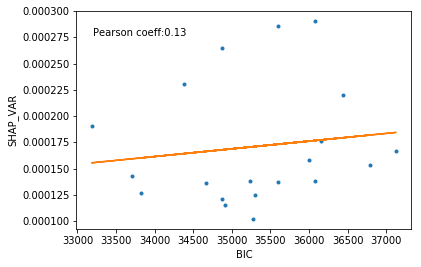

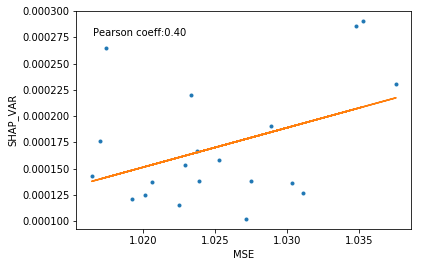

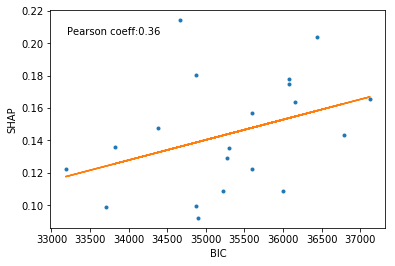

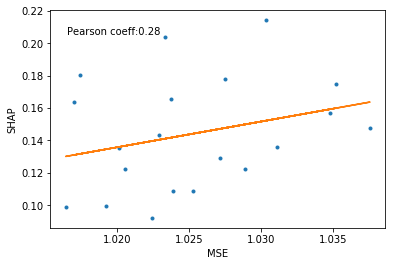

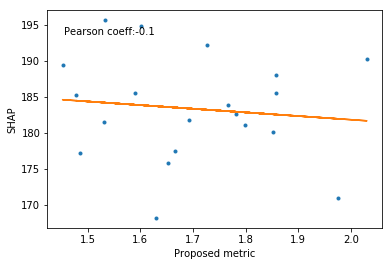

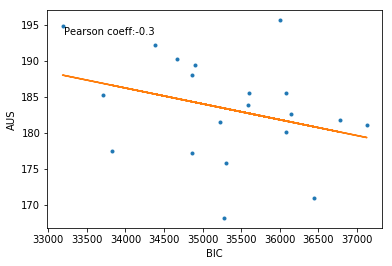

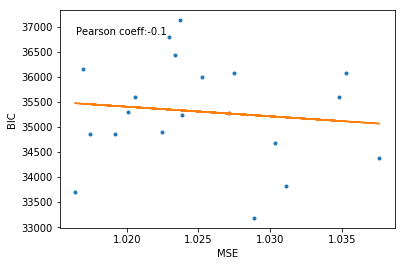

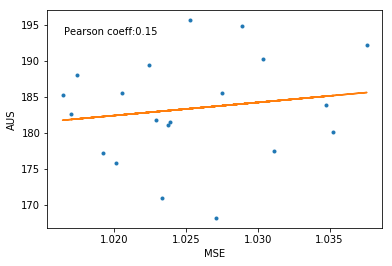

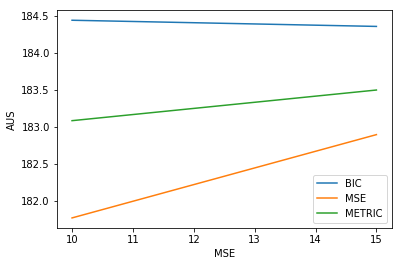

-0.11507737877491485

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(MSE,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP, 1)
ax.plot(MSE,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (SHAP/np.max(SHAP)) + np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO,AUS, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,VIO, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,VIO)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,VIO, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("BIC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [8]:
def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + np.array(MSE)
n_low = 5

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(VIO,SHAP_VAR))]
print("SHAP VAR Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(MSE,SHAP_VAR))]
print("SHAP VAR Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(METRIC,SHAP_VAR))]
print("SHAP VAR Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP VAR Random = ", np.mean(SHAP_VAR[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(VIO,SHAP))]
print("SHAP Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(MSE,SHAP))]
print("SHAP Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP for _,SHAP in sorted(zip(METRIC,SHAP))]
print("SHAP Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP Random = ", np.mean(SHAP[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("AUS Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("AUS Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("AUS Best by MET = ", np.mean(sorted_aus[:n_low]))
print("AUS Random = ", np.mean(AUS[:n_low]))

SHAP VAR Best by BIC =  0.0001655914670990742
SHAP VAR Best by MSE =  0.00016604901289933344
SHAP VAR Best by MET =  0.0001655914670990742
SHAP VAR Random =  0.00019092523971027997
SHAP Best by BIC =  0.14390239298571333
SHAP Best by MSE =  0.13563660749594514
SHAP Best by MET =  0.14390239298571333
SHAP Random =  0.14961815837486228
AUS Best by BIC =  188.00667688382504
AUS Best by MSE =  181.80273946685733
AUS Best by MET =  188.00667688382504
AUS Random =  179.23746356170656


/home/tkyono/anaconda3/lib/python3.6/site-packages/shap/explainers/deep/deep_tf.py:138: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


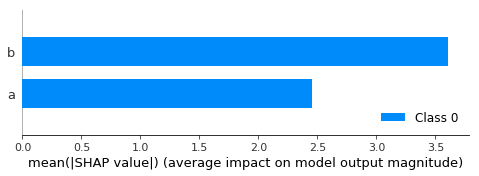

[2.4542249289007945, 3.603755623667226]

In [9]:
import shap
shap.initjs()
samples = 200
df = gen_data(mean = 2, var = 3)
x_train = df[inputs]
explainer_shap = shap.DeepExplainer(model=model, data=x_train)
shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
l = []
for f, feat in enumerate(inputs):
    tot = 0
    for i in shap_values[0]:
        for j in i:
            tot += np.abs(j[f])
    l.append(tot/samples)
l

